In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

from precip_model_functions import *#precip_model_OGorman,retrieve_modeled_precip,lr,lrp,corrc,corrp

from scipy.optimize import minimize, root_scalar

In [2]:
#SEE https://unidata.github.io/MetPy/latest/examples/Advanced_Sounding.html#sphx-glr-examples-advanced-sounding-py

# Functions

In [3]:
#Data extraction from ERA5
import warnings
era5yrs = list(range(2010,2019))
ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"

def era5_file(year,varid):
    """return file path to an ERA5 variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    try :
        fpath = glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    except IndexError :
        path = "/global/cscratch1/sd/qnicolas/era5monthly/"
        fpath = glob.glob(os.path.join(path,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    return fpath

def climatology_era5(varid,lonlat,level=800.):
    t=time.time()
    paths = [era5_file(year,varid) for year in era5yrs]
    temp=0
    for p in paths:
        ds = xr.open_dataset(p)
        ds.coords['month'] = ds['time.month']
        ds = ds.swap_dims({'time': 'month'}).drop('time')
        if 'level' in ds.coords:
            temp2=ds.sel(level=level,longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
        else:
            temp2=ds.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
            
        if p == paths[0]:
            temp=temp2
        else :
            temp+=temp2
    varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    return temp[varname]/len(paths)

def climatology_era5_vertprofile(varid,lonlat,month):
    t=time.time()
    paths = [era5_file(year,varid) for year in era5yrs]
    temp=0
    for p in paths:
        ds = xr.open_dataset(p)
        ds.coords['month'] = ds['time.month']
        ds = ds.swap_dims({'time': 'month'}).drop('time')
        temp2=ds.sel(month=month,longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).mean(["latitude","longitude"])
        if p == paths[0]:
            temp=temp2
        else :
            temp+=temp2
    varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    return temp[varname]/len(paths)

def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    if type(mask)==int:
        region_mean = mask*variable_box.fillna(0).mean(["latitude","longitude"])
    else:
        mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        maskedvar = variable_box*mask_box
        region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean

def region_mean2D_trmm(variable,mask,box):
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
    if type(mask)==int:
        region_mean = mask*variable_box.fillna(0).mean(["latitude","longitude"])
    else:
        mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
        maskedvar = variable_box*mask_box
        region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean



# Test on the Western ghats

In [6]:
box_upstream = [72, 73, 11, 15]
box_downstream = [74, 75, 11, 15]
box_ct=[72, 75, 11, 15]

In [7]:
ct="ghats"
pr_e5_seasmean = 1000*climatology_era5('128_228_tp',box_ct)

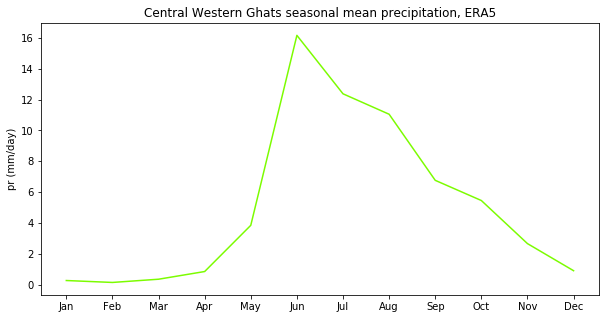

In [182]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.plot(mnths,region_mean2D(pr_e5_seasmean,1,box_ct),color='lawngreen',label="ERA5 pr")
ax.set_title(names[ct]+" seasonal mean precipitation, ERA5")
ax.set_ylabel('pr (mm/day)');None

In [8]:
#rainiest month
rmonth=6
#mean profiles
T_e5_rmmean = climatology_era5_vertprofile('128_130_t',box_ct,rmonth)
q_e5_rmmean = climatology_era5_vertprofile('128_133_q',box_ct,rmonth)
omega_e5_rmmean = climatology_era5_vertprofile('128_135_w',box_ct,rmonth)

In [9]:
#mean june rh
r_e5_rmmean = climatology_era5_vertprofile('*_r',box_ct,rmonth)

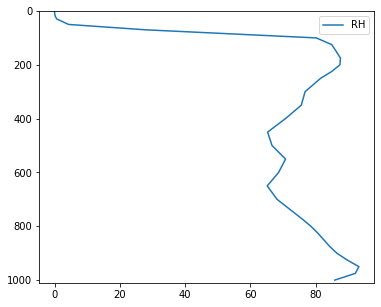

In [185]:
_,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(r_e5_rmmean,r_e5_rmmean.level,label="RH")
ax.set_ylim(1010,0)
ax.legend()

In [10]:
# compute T0 and q0
#start by computing mean SST, extrapolate with moist adiabat
t2m_e5_rmmean=np.array(climatology_era5('*_2t',box_ct).sel(month=rmonth).mean())

e5_pressures=np.array(T_e5_rmmean.level)
madiabat_profile=np.array(mpcalc.moist_lapse(e5_pressures*units.hPa,t2m_e5_rmmean*units.K,ref_pressure=1000*units.hPa))
madiabat_profile=np.append(madiabat_profile,t2m_e5_rmmean)


#compute q0 as 70%RH
qsat = np.array(mpcalc.saturation_mixing_ratio(e5_pressures*units.hPa,madiabat_profile*units.K))
q0 = xr.DataArray(0.7*qsat,[('level', e5_pressures)])

#correct T0 in the stratosphere
tropindex=10
madiabat_profile[:tropindex]=madiabat_profile[tropindex]+.5*(e5_pressures[tropindex]-e5_pressures[:tropindex])
T0=xr.DataArray(madiabat_profile,[('level', e5_pressures)])

(Text(0.5, 0, 'g/kg'), 'None')

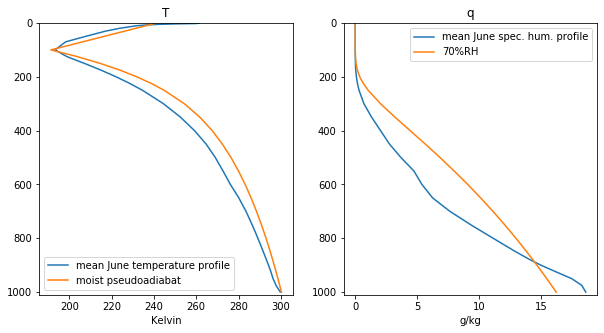

In [191]:
_,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(T_e5_rmmean,T_e5_rmmean.level,label="mean June temperature profile")
ax[0].plot(T0,T0.level,label="moist pseudoadiabat")
ax[0].set_ylim(1010,0)
ax[0].set_xlabel("Kelvin")
ax[0].set_title("T")
ax[0].legend()

ax[1].plot(1000*q_e5_rmmean,q_e5_rmmean.level,label="mean June spec. hum. profile")
ax[1].plot(1000*q0,q0.level,label="70%RH")
ax[1].set_ylim(1010,0)
ax[1].set_title("q")
ax[1].legend()
ax[1].set_xlabel("g/kg"),"None"

In [11]:
#Compute Ttilde,Omegatilde,qtilde
Ttilde = (T_e5_rmmean-T0)
Ttilde=Ttilde/(Ttilde.integrate("level")/1000)

qtilde = (q_e5_rmmean-q0)
qtilde=qtilde/(qtilde.integrate("level")/1000)

omegatilde=omega_e5_rmmean/(omega_e5_rmmean.integrate("level")/1000)

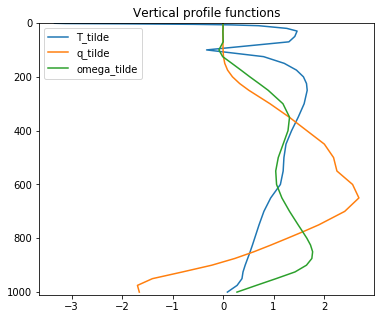

In [193]:
_,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(Ttilde,Ttilde.level,label="T_tilde")
ax.plot(qtilde,qtilde.level,label="q_tilde")
ax.plot(omegatilde,omegatilde.level,label="omega_tilde")
ax.set_ylim(1010,0)
ax.set_title("Vertical profile functions")
ax.legend()

In [12]:
# Estimate the terms of the moisture perturbation equation
# START ENERGY UNITS NOW
Lv = 2.3e6 #J/kg
Cp = 1e3 #J/kg/Kelvin
alpha_hat = np.array((omegatilde*Lv*q0.differentiate('level')/100).integrate('level')/1000)
beta_hat = np.array((omegatilde*qtilde.differentiate('level')/100).integrate('level')/1000)

u_h = 15 #mean horizontal wind, m/s
L = 100e3 #distance in m between upstream region and mountain
q_upstream = climatology_era5_vertprofile('128_133_q',box_upstream,rmonth)
q1_upstream = minimize(lambda q1 : np.array(((q_upstream-q0-q1*qtilde)**2).integrate('level')),0.).x
tau_c=7000 #comvective adjustment time scale in s



In [16]:
T_upstream = climatology_era5_vertprofile('128_130_t',box_upstream,rmonth)
theta_upstream = T_upstream *(T_upstream.level/1000.)**(-0.286)
S = T_upstream/theta_upstream * (theta_upstream.differentiate('level')/100)

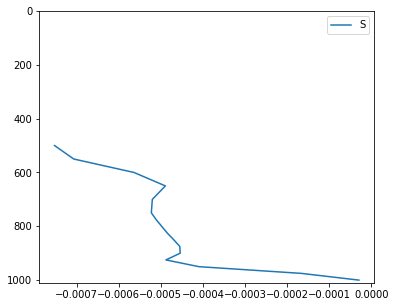

In [196]:
_,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(S.sel(level=slice(500,1000)),S.sel(level=slice(500,1000)).level,label="S")
ax.set_ylim(1010,0)
ax.legend()

In [17]:
S = -5e-4#stability parameter in K/Pa
cape_upstream = np.array(climatology_era5_vertprofile('*_cape',box_upstream,rmonth))
T1 = (Lv*q1_upstream-cape_upstream)/Cp

In [198]:
q1_upstream

array([-0.00155043])

In [202]:
def f(q1):
    return u_h*Lv*(q1-q1_upstream)/L + np.maximum(Lv*q1-Cp*T1,0.)/tau_c * (1+alpha_hat/(Cp*S)+Lv*q1*beta_hat/(Cp*S))

Text(0, 0.5, 'J/s')

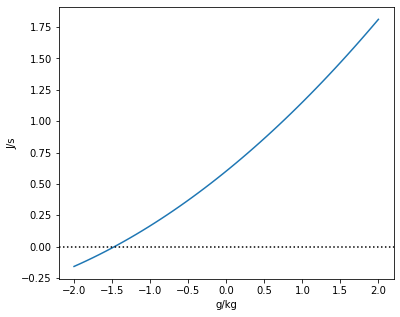

In [204]:
q1=np.linspace(-2e-3,2e-3)
_,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(1000*q1,f(q1))
ax.axhline(0.,linestyle=':',color='k')
ax.set_xlabel("g/kg")
ax.set_ylabel("J/s")



In [205]:
q1_sol=root_scalar(f,x0=-1e-3,x1=1e-3).root
omega1_sol=np.maximum(Lv*q1_sol-Cp*T1,0.)/tau_c/(Cp*S)
print("q1 : %.2f g/kg"%(1000*q1_sol))
print("Omega : %.2f Pa s-1"%omega1_sol)

q1 : -1.47 g/kg
Omega : -0.37 Pa s-1


Text(0.5, 1.0, 'Omega profiles')

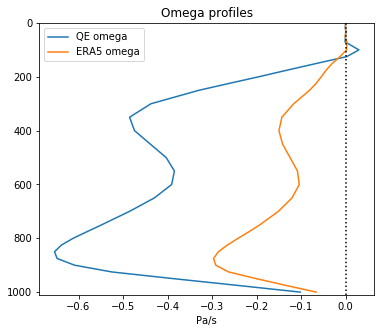

In [206]:

omega_downstream = climatology_era5_vertprofile('128_135_w',box_downstream,rmonth)
_,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(omega1_sol*omegatilde,omegatilde.level,label="QE omega")
ax.plot(omega_downstream,omega_downstream.level,label="ERA5 omega")
ax.axvline(0.,linestyle=':',color='k')
ax.set_xlabel("Pa/s")
ax.set_ylim(1010,0)
ax.legend()
ax.set_title("Omega profiles")

# Factoring code

In [226]:
def plot_seasmeanpr(name_ct,box_ct):
    pr_e5_seasmean = 1000*climatology_era5('128_228_tp',box_ct)
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    ax.plot(mnths,region_mean2D(pr_e5_seasmean,1,box_ct),color='lawngreen',label="ERA5 pr")
    ax.set_title(name_ct+" seasonal mean precipitation, ERA5")
    ax.set_ylabel('pr (mm/day)');None
    
def QEscaling(rmonth,box_upstream,box_downstream,box_ct,u_h):
    T_e5_rmmean = climatology_era5_vertprofile('128_130_t',box_ct,rmonth)
    q_e5_rmmean = climatology_era5_vertprofile('128_133_q',box_ct,rmonth)
    omega_e5_rmmean = climatology_era5_vertprofile('128_135_w',box_ct,rmonth)
    
    # compute T0 and q0
    #start by computing mean SST, extrapolate with moist adiabat
    t2m_e5_rmmean=np.array(climatology_era5('*_2t',box_ct).sel(month=rmonth).mean())
    
    e5_pressures=np.array(T_e5_rmmean.level)
    madiabat_profile=np.array(mpcalc.moist_lapse(e5_pressures*units.hPa,t2m_e5_rmmean*units.K,ref_pressure=1000*units.hPa))
    madiabat_profile=np.append(madiabat_profile,t2m_e5_rmmean)
    
    #compute q0 as 70%RH
    qsat = np.array(mpcalc.saturation_mixing_ratio(e5_pressures*units.hPa,madiabat_profile*units.K))
    q0 = xr.DataArray(0.7*qsat,[('level', e5_pressures)])
    
    #correct T0 in the stratosphere
    tropindex=10
    madiabat_profile[:tropindex]=madiabat_profile[tropindex]+.5*(e5_pressures[tropindex]-e5_pressures[:tropindex])
    T0=xr.DataArray(madiabat_profile,[('level', e5_pressures)])
    
    #plot reference profiles
    _,ax=plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(T_e5_rmmean,T_e5_rmmean.level,label="mean %s temperature profile"%(mnths[rmonth-1]))
    ax[0].plot(T0,T0.level,label="moist pseudoadiabat")
    ax[0].set_ylim(1010,0)
    ax[0].set_xlabel("Kelvin")
    ax[0].set_title("T")
    ax[0].legend()
    
    ax[1].plot(1000*q_e5_rmmean,q_e5_rmmean.level,label="mean %s spec. hum. profile"%(mnths[rmonth-1]))
    ax[1].plot(1000*q0,q0.level,label="80%RH")
    ax[1].set_ylim(1010,0)
    ax[1].set_title("q")
    ax[1].legend()
    ax[1].set_xlabel("g/kg"),"None"
    
    #Compute Ttilde,Omegatilde,qtilde
    Ttilde = (T_e5_rmmean-T0)
    Ttilde=Ttilde/(Ttilde.integrate("level")/1000)
    
    qtilde = (q_e5_rmmean-q0)
    qtilde=qtilde/(qtilde.integrate("level")/1000)
    
    omegatilde=omega_e5_rmmean/(omega_e5_rmmean.integrate("level")/1000)
    #Plot Ttilde,Omegatilde,qtilde
    _,ax=plt.subplots(1,1,figsize=(6,5))
    ax.plot(Ttilde,Ttilde.level,label="T_tilde")
    ax.plot(qtilde,qtilde.level,label="q_tilde")
    ax.plot(omegatilde,omegatilde.level,label="omega_tilde")
    ax.set_ylim(1010,0)
    ax.set_title("Vertical profile functions")
    ax.legend()
    
    # Estimate the terms of the moisture perturbation equation
    # START ENERGY UNITS NOW
    Lv = 2.3e6 #J/kg
    Cp = 1e3 #J/kg/Kelvin
    alpha_hat = np.array((omegatilde*Lv*q0.differentiate('level')/100).integrate('level')/1000)
    beta_hat = np.array((omegatilde*qtilde.differentiate('level')/100).integrate('level')/1000)
    
    L = 200e3 #distance in m between upstream region and mountain
    q_upstream = climatology_era5_vertprofile('128_133_q',box_upstream,rmonth)
    q1_upstream = minimize(lambda q1 : np.array(((q_upstream-q0-q1*qtilde)**2).integrate('level')),0.).x
    tau_c=7000 #comvective adjustment time scale in s
    
    T_upstream = climatology_era5_vertprofile('128_130_t',box_upstream,rmonth)
    theta_upstream = T_upstream *(T_upstream.level/1000.)**(-0.286)
    Sprofile = T_upstream/theta_upstream * (theta_upstream.differentiate('level')/100)
    _,ax=plt.subplots(1,1,figsize=(6,5))
    ax.plot(Sprofile.sel(level=slice(500,1000)),Sprofile.sel(level=slice(500,1000)).level,label="S")
    ax.set_ylim(1010,0)
    ax.set_title("Lapse rate")
    ax.legend()
    S = np.array(Sprofile.sel(level=slice(500.,800.)).mean())#stability parameter in K/Pa
    print("Stability parameter : %.2e K/Pa"%S)
    
    cape_upstream = np.array(climatology_era5_vertprofile('*_cape',box_upstream,rmonth))
    T1 = (Lv*q1_upstream-cape_upstream)/Cp
    
    def obj_func(q1):
        return u_h*Lv*(q1-q1_upstream)/L + np.maximum(Lv*q1-Cp*T1,0.)/tau_c * (1+alpha_hat/(Cp*S)+Lv*q1*beta_hat/(Cp*S))
    
    q1_sol=root_scalar(obj_func,x0=-1e-3,x1=1e-3).root
    omega1_sol=np.maximum(Lv*q1_sol-Cp*T1,0.)/tau_c/(Cp*S)
    print("q1 : %.2f g/kg"%(1000*q1_sol))
    print("Omega : %.2f Pa s-1"%omega1_sol)
    
    omega_downstream = climatology_era5_vertprofile('128_135_w',box_downstream,rmonth)
    _,ax=plt.subplots(1,1,figsize=(6,5))
    ax.plot(omega1_sol*omegatilde,omegatilde.level,label="QE omega")
    ax.plot(omega_downstream,omega_downstream.level,label="ERA5 omega")
    ax.axvline(0.,linestyle=':',color='k')
    ax.set_xlabel("Pa/s")
    ax.set_ylim(1010,0)
    ax.legend()
    ax.set_title("Omega profiles")

In [231]:
u500 = climatology_era5("128_131_u",box_upstream_ghats,level=500.).sel(month=6)

In [234]:
u800 = climatology_era5("128_131_u",box_upstream_ghats,level=800.).sel(month=6)

In [233]:
print("mean wind 500 hpa upstream of the ghats: %.2f m/s"%u500.mean())
print("mean wind 800 hpa upstream of the ghats: %.2f m/s"%u800.mean())

mean wind 500 hpa upstream of the ghats: 4.81 m/s


Stability parameter : -5.70e-04 K/Pa
q1 : -1.53 g/kg
Omega : -0.29 Pa s-1


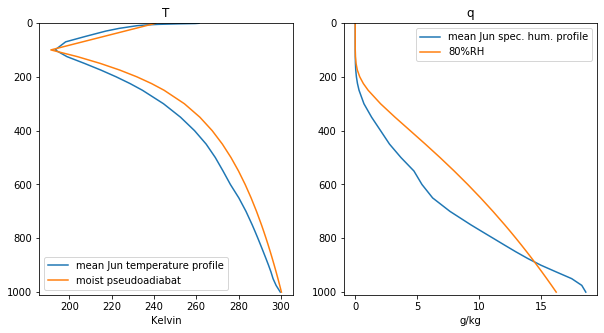

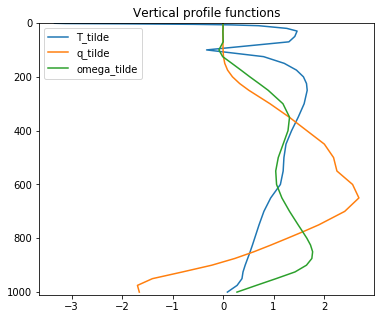

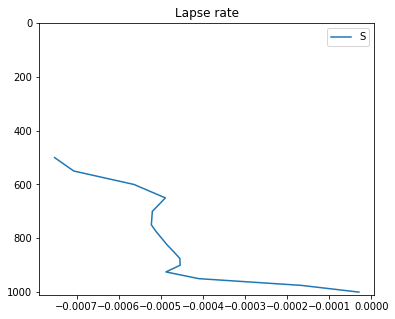

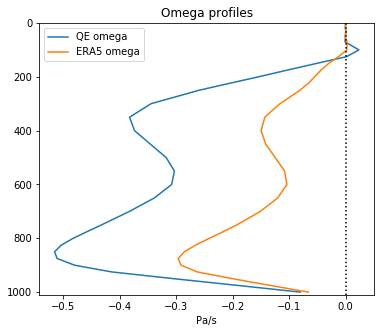

In [228]:
box_upstream_ghats = [72, 73, 11, 15]
box_downstream_ghats = [74, 75, 11, 15]
box_ct_ghats=[72, 75, 11, 15]
QEscaling(6,box_upstream_ghats,box_downstream_ghats,box_ct_ghats,10.)

In [211]:
box_upstream_malaysia = [104,107,1,6]
box_downstream_malaysia = [102,104,1,6]
box_ct_malaysia = [102,107,1,6]

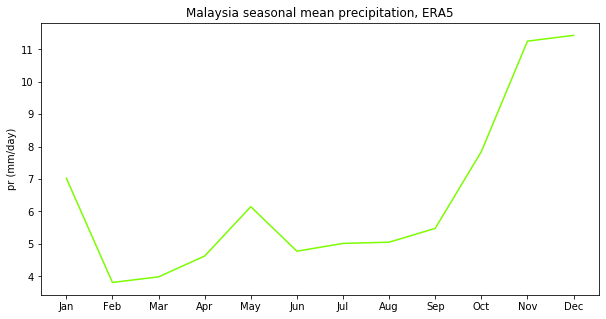

In [218]:
plot_seasmeanpr("Malaysia",box_ct_malaysia)

Stability parameter : -5.67e-04 K/Pa
q1 : -1.38 g/kg
Omega : -0.07 Pa s-1


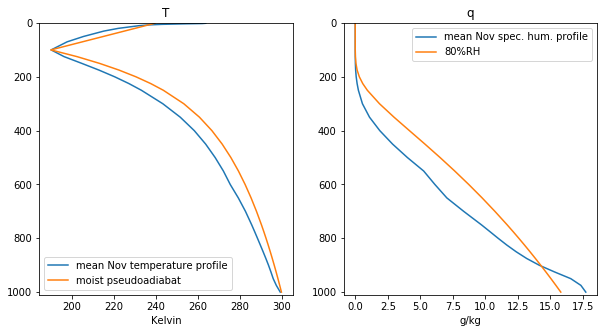

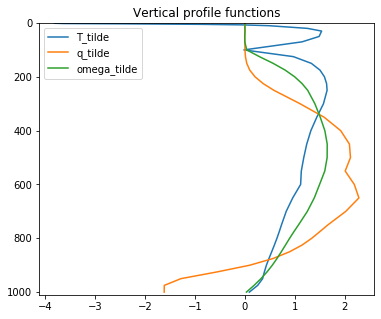

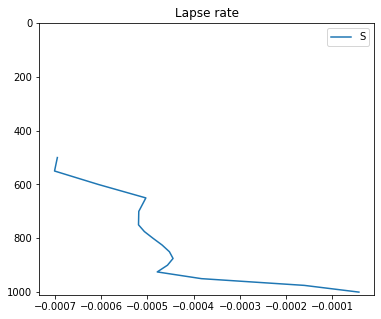

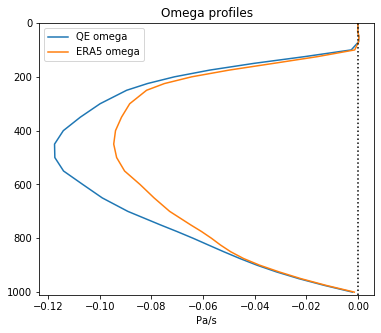

In [219]:
QEscaling(11,box_upstream_malaysia,box_downstream_malaysia,box_ct_malaysia,5.)

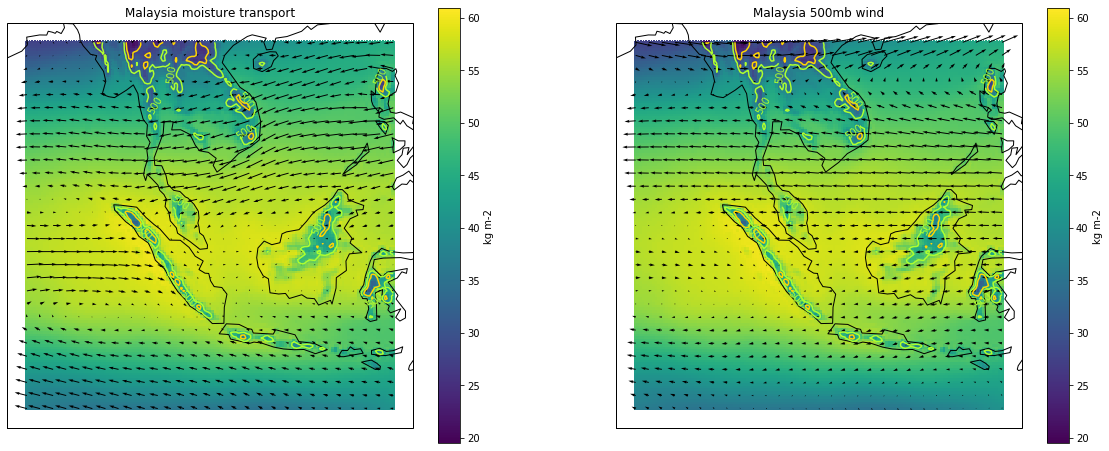

In [221]:
lonlat = [102,107,1,6]+15*np.array([-1,1,-1,1])
uq   = climatology_era5("*_viwve",lonlat).sel(month=11)
vq   = climatology_era5("*_viwvn",lonlat).sel(month=11)
u500 = climatology_era5("128_131_u",lonlat,level=500.).sel(month=11)
v500 = climatology_era5("128_132_v",lonlat,level=500.).sel(month=11)
tcwv = climatology_era5("*_tcwv",lonlat).sel(month=11)


fig, ax = plt.subplots(1,2,figsize=(20,8),subplot_kw={'projection': ccrs.PlateCarree()})
for a in ax:
    tcwv.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot(ax=a,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"kg m-2"})
    kw = {'levels':[500.,1000.], 'colors':['greenyellow','gold']}#,'linewidths':0.5}
    contour=orog.isel(time=0).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot.contour(ax=a,transform=ccrs.PlateCarree(),**kw)
    a.clabel(contour, inline=1, fontsize=10, fmt="%i")
    a.coastlines()
ax[0].set_title("Malaysia"+ " moisture transport")
ax[1].set_title("Malaysia"+ " 500mb wind")

#Wind Vectors
for a,uq,vq in zip(ax,[uq,u500],[vq,v500]):
    uq=uq.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))[::5,::5]
    vq=vq.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))[::5,::5]
    X = uq.latitude.expand_dims({"longitude":uq.longitude}).transpose()
    Y = uq.longitude.expand_dims({"latitude":uq.latitude})
    Q = a.quiver(np.array(Y),np.array(X), np.array(uq), np.array(vq), transform=ccrs.PlateCarree(),color="k",linewidth=1)#,scale=100,scale_units="height") #np.hypot(np.array(u),np.array(v)) to color the arrows according to magnitude
    #qk = a.quiverkey(Q, 0., 0., 1, '1 kg/m/s', labelpos='E',coordinates='figure')


In [222]:
np.sqrt(u500.mean()**2+v500.mean()**2)

<xarray.DataArray ()>
array(2.0082896, dtype=float32)
Coordinates:
    level    float64 500.0
    month    int64 11

In [235]:
box_upstream_nepal=[85,95,23,25.5]
box_downstream_nepal=[85,95,25.5,27.5]
box_ct_nepal=[85,95,23,27.5]

In [238]:
v800him = climatology_era5("128_132_v",box_upstream_nepal,level=800.).sel(month=7)
print("mean v wind 800 hpa upstream of the Himalayas: %.2f m/s"%v800him.mean())

mean v wind 800 hpa upstream of the Himalayas: 3.67 m/s


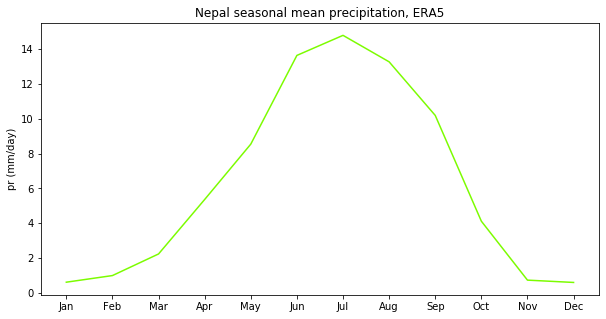

In [237]:
plot_seasmeanpr("Nepal",box_ct_nepal)

Stability parameter : -6.19e-04 K/Pa
q1 : 0.04 g/kg
Omega : -0.12 Pa s-1


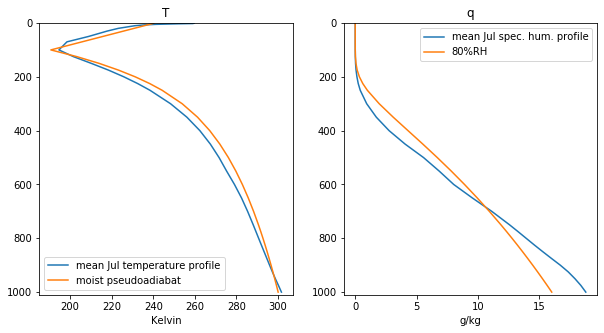

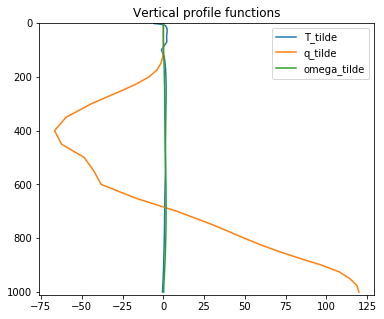

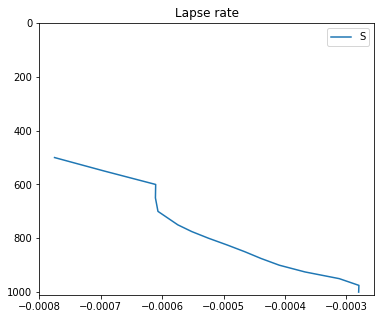

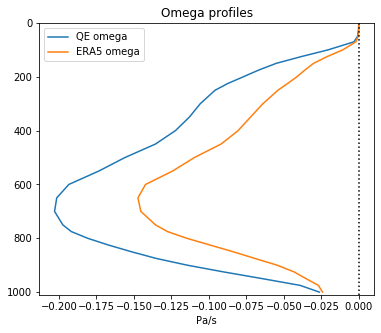

In [239]:
QEscaling(7,box_upstream_nepal,box_downstream_nepal,box_ct_nepal,4)

In [242]:
alpha_hat

array(0.44968838)

In [13]:
alpha_hat

array(0.44968838)

In [14]:
beta_hat

array(-3.71726925e-05)

In [18]:
Cp*T1

array([-4670.59903581])

In [3]:
import numpy as np
def f(x):
    if x==1:
        return np.exp(0.2)-1
    else :
        return x**(0.2*x/(x-1))-1

In [4]:
f(1)

0.22140275816016985

In [6]:
f(2)/f(1)

1.4431071836139997

In [7]:
f(4)/f(1)

2.02016109084246